In [3]:
IMAGE_PATH='/Users/pingwang/code/kaggle/leaf/images'

In [66]:
import os
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

# If you want to use Theano, all you need to change
# is the dim ordering whenever you are dealing with
# the image array. Instead of
# (samples, rows, cols, channels) it should be
# (samples, channels, rows, cols)

# Keras stuff
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import img_to_array, load_img

# A large amount of the data loading code is based on najeebkhan's kernel
# Check it out at https://www.kaggle.com/najeebkhan/leaf-classification/neural-network-through-keras
root = '.'
np.random.seed(2016)
split_random_state = 7
split = .9


def load_numeric_training(standardize=True):
    """
    Loads the pre-extracted features for the training data
    and returns a tuple of the image ids, the data, and the labels
    """
    # Read data from the CSV file
    data = pd.read_csv(os.path.join(root, 'train.csv'))
    ID = data.pop('id')

    # Since the labels are textual, so we encode them categorically
    y = data.pop('species')
    y = LabelEncoder().fit(y).transform(y)
    # standardize the data by setting the mean to 0 and std to 1
    X = StandardScaler().fit(data).transform(data) if standardize else data.values

    return ID, X, y


def load_numeric_test(standardize=True):
    """
    Loads the pre-extracted features for the test data
    and returns a tuple of the image ids, the data
    """
    test = pd.read_csv(os.path.join(root, 'test.csv'))
    ID = test.pop('id')
    # standardize the data by setting the mean to 0 and std to 1
    test = StandardScaler().fit(test).transform(test) if standardize else test.values
    return ID, test


def resize_img(img, max_dim=96):
    """
    Resize the image to so the maximum side is of size max_dim
    Returns a new image of the right size
    """
    # Get the axis with the larger dimension
    max_ax = max((0, 1), key=lambda i: img.size[i])
    # Scale both axes so the image's largest dimension is max_dim
    scale = max_dim / float(img.size[max_ax])
    return img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))


def load_image_data(ids, max_dim=96, center=True):
    """
    Takes as input an array of image ids and loads the images as numpy
    arrays with the images resized so the longest side is max-dim length.
    If center is True, then will place the image in the center of
    the output array, otherwise it will be placed at the top-left corner.
    """
    # Initialize the output array
    # NOTE: Theano users comment line below and
    X = np.empty((len(ids), max_dim, max_dim, 1))
    # X = np.empty((len(ids), 1, max_dim, max_dim)) # uncomment this
    for i, idee in enumerate(ids):
        # Turn the image into an array
        x = resize_img(load_img(os.path.join(root, 'images', str(idee) + '.jpg'), grayscale=True), max_dim=max_dim)
        x = img_to_array(x)
        # Get the corners of the bounding box for the image
        # NOTE: Theano users comment the two lines below and
        length = x.shape[0]
        width = x.shape[1]
        # length = x.shape[1] # uncomment this
        # width = x.shape[2] # uncomment this
        if center:
            h1 = int((max_dim - length) / 2)
            h2 = h1 + length
            w1 = int((max_dim - width) / 2)
            w2 = w1 + width
        else:
            h1, w1 = 0, 0
            h2, w2 = (length, width)
        # Insert into image matrix
        # NOTE: Theano users comment line below and
        X[i, h1:h2, w1:w2, 0:1] = x
        # X[i, 0:1, h1:h2, w1:w2] = x  # uncomment this
    # Scale the array values so they are between 0 and 1
    return np.around(X / 255.0)


def load_train_data(split=split, random_state=None):
    """
    Loads the pre-extracted feature and image training data and
    splits them into training and cross-validation.
    Returns one tuple for the training data and one for the validation
    data. Each tuple is in the order pre-extracted features, images,
    and labels.
    """
    # Load the pre-extracted features
    ID, X_num_tr, y = load_numeric_training()
    # Load the image data
    X_img_tr = load_image_data(ID)
    # Split them into validation and cross-validation
    sss = StratifiedShuffleSplit(n_splits=1, train_size=split, random_state=random_state)
    train_ind, test_ind = next(sss.split(X_num_tr, y))
    X_num_val, X_img_val, y_val = X_num_tr[test_ind], X_img_tr[test_ind], y[test_ind]
    X_num_tr, X_img_tr, y_tr = X_num_tr[train_ind], X_img_tr[train_ind], y[train_ind]
    return (X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val)


def load_test_data():
    """
    Loads the pre-extracted feature and image test data.
    Returns a tuple in the order ids, pre-extracted features,
    and images.
    """
    # Load the pre-extracted features
    ID, X_num_te = load_numeric_test()
    # Load the image data
    X_img_te = load_image_data(ID)
    return ID, X_num_te, X_img_te

print('Loading the training data...')
(X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val) = load_train_data(random_state=split_random_state)
y_tr_cat = to_categorical(y_tr)
y_val_cat = to_categorical(y_val)
print('Training data loaded!')

Loading the training data...
Training data loaded!


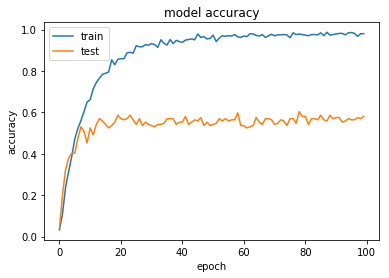

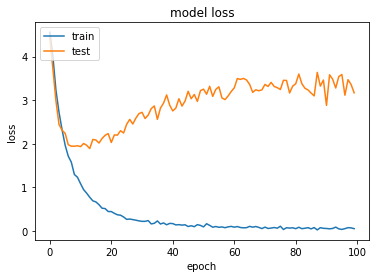

In [152]:
def plot_model_measure(history):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
#     for k in history.keys():
#         plt.plot(history[k], label=k)
    legend = ax.legend(loc='upper right', shadow=True)
#     plt.show()

plot_model_measure(model.history.history)

In [147]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.layers import Convolution2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, merge
from keras.models import Model
import numpy as np
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Convolution2D, MaxPooling2D, Flatten, Input, merge


def create_model():

    # Define the image input
    image = Input(shape=(96, 96, 1), name='image')
    # Pass it through the first convolutional layer
    x = Convolution2D(8, 5, 5, input_shape=(96, 96, 1), border_mode='same')(image)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Now through the second convolutional layer
    x = (Convolution2D(32, 5, 5, border_mode='same'))(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Flatten our array
    x = Flatten()(x)

    # Add a fully connected layer just like in a normal MLP
    x = Dense(100, activation='relu', name='dense1')(x)
    x = Dropout(.5)(x)

    # Get the final output
    out = Dense(99, activation='softmax', name='dense2')(x)
    # How we create models with the Functional API
    model = Model(input=image, output=out)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

print('Creating the model...')
model = create_model()
print('Model created!')

model.fit(X_img_tr, y_tr_cat, nb_epoch=100, batch_size=32, validation_split=0.2)



Creating the model...
Model created!
Train on 712 samples, validate on 179 samples
Epoch 1/100
712/712 [==============================] - 6s - loss: 4.5573 - acc: 0.0323 - val_loss: 4.4299 - val_acc: 0.0391

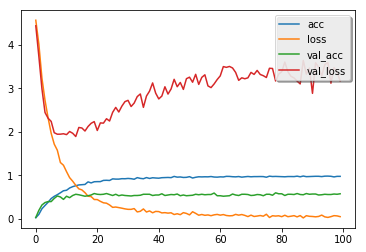

In [148]:
plot_model_measure(model.history.history)
# model.history.history.keys()



In [157]:
def combined_model():

    # Define the image input
    image = Input(shape=(96, 96, 1), name='image')
    # Pass it through the first convolutional layer
    x = Convolution2D(8, 5, 5, input_shape=(96, 96, 1), border_mode='same')(image)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Now through the second convolutional layer
    x = (Convolution2D(32, 5, 5, border_mode='same'))(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Flatten our array
    x = Flatten()(x)
    # Define the pre-extracted feature input
    numerical = Input(shape=(192,), name='numerical')
    # Concatenate the output of our convnet with our pre-extracted feature input
    concatenated = merge([x, numerical], mode='concat')

    # Add a fully connected layer just like in a normal MLP
    x = Dense(100, activation='relu')(concatenated)
    x = Dropout(.5)(x)

    # Get the final output
    out = Dense(99, activation='softmax')(x)
    # How we create models with the Functional API
    model = Model(input=[image, numerical], output=out)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

print('Creating the model...')
model = combined_model()
print('Model created!')

best_model_file = "leafnet.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
history = model.fit([X_img_tr, X_num_tr], y_tr_cat,
                              nb_epoch=89,
                              validation_data=([X_img_val, X_num_val], y_val_cat),
                              verbose=0,
                              callbacks=[best_model])

Creating the model...
Model created!
Training model...
Epoch 00000: val_loss improved from inf to 3.16179, saving model to leafnet.h5
Epoch 00001: val_loss improved from 3.16179 to 1.87810, saving model to leafnet.h5
Epoch 00002: val_loss improved from 1.87810 to 1.09550, saving model to leafnet.h5
Epoch 00003: val_loss improved from 1.09550 to 0.80224, saving model to leafnet.h5
Epoch 00004: val_loss improved from 0.80224 to 0.61539, saving model to leafnet.h5
Epoch 00005: val_loss improved from 0.61539 to 0.54876, saving model to leafnet.h5
Epoch 00006: val_loss improved from 0.54876 to 0.48496, saving model to leafnet.h5
Epoch 00007: val_loss improved from 0.48496 to 0.41136, saving model to leafnet.h5
Epoch 00008: val_loss improved from 0.41136 to 0.40035, saving model to leafnet.h5
Epoch 00009: val_loss improved from 0.40035 to 0.40019, saving model to leafnet.h5
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss improved from 0.40019 to 0.38465, saving model to leafnet.h

In [149]:
plot_model_measure(model.history.history)

SyntaxError: invalid syntax (<ipython-input-149-feb280bfa6c0>, line 43)

In [106]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.layers import Convolution2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, merge
from keras.models import Model
import numpy as np
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Convolution2D, MaxPooling2D, Flatten, Input, merge


def create_model():

    # Define the image input
    image = Input(shape=(96, 96, 1), name='image')
    # Pass it through the first convolutional layer
    x = Convolution2D(16, 3, 3, input_shape=(96, 96, 1), border_mode='same')(image)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Now through the second convolutional layer
    x = (Convolution2D(32, 5, 5, border_mode='same'))(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Flatten our array
    x = Flatten()(x)

    # Add a fully connected layer just like in a normal MLP
    x = Dense(100, activation='relu', name='dense1')(x)
    x = Dropout(.5)(x)

    # Get the final output
    out = Dense(99, activation='softmax', name='dense2')(x)
    # How we create models with the Functional API
    model = Model(input=image, output=out)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

print('Creating the model...')
model = create_model()
print('Model created!')
model.fit(X_img_tr, y_tr_cat, nb_epoch=10, batch_size=32)

plot_model_measure(model.history.history)

Creating the model...
Model created!
Epoch 1/10
891/891 [==============================] - 13s - loss: 4.5115 - acc: 0.0292         

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.layers import Convolution2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, merge
from keras.models import Model
import numpy as np
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Convolution2D, MaxPooling2D, Flatten, Input, merge


def create_model():

    # Define the image input
    image = Input(shape=(96, 96, 1), name='image')
    # Pass it through the first convolutional layer
    x = Convolution2D(32, 3, 3, input_shape=(96, 96, 1), border_mode='same')(image)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Now through the second convolutional layer
    x = (Convolution2D(64, 5, 5, border_mode='same'))(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Flatten our array
    x = Flatten()(x)

    # Add a fully connected layer just like in a normal MLP
    x = Dense(256, activation='relu', name='dense1')(x)
    x = Dropout(.5)(x)

    # Get the final output
    out = Dense(99, activation='softmax', name='dense2')(x)
    # How we create models with the Functional API
    model = Model(input=image, output=out)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

print('Creating the model...')
model = create_model()
print('Model created!')
model.fit(X_img_tr, y_tr_cat, nb_epoch=100, batch_size=32, validation_split=0.2)

plot_model_measure(model.history.history)

In [114]:
# simple feature based 
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Convolution2D, MaxPooling2D, Flatten, Input, merge


def create_model():

    # Define the pre-extracted feature input
    numerical = Input(shape=(192,), name='numerical')

    # Add a fully connected layer just like in a normal MLP
    x = Dense(100, activation='relu')(numerical)
#     x = Dropout(.5)(x)

    # Get the final output
    out = Dense(99, activation='softmax')(x)
    # How we create models with the Functional API
    model = Model(input=[numerical], output=out)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

print('Creating the model...')
model = create_model()
print('Model created!')

from keras.callbacks import ModelCheckpoint
from keras.models import load_model

print('Training model...')
best_model_file = "simple_leafnet.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)


history = model.fit(X_num_tr, y_tr_cat, nb_epoch=16, validation_split = 0.2)


plot_model_measure(model.history.history)


Creating the model...
Model created!
Training model...
Train on 712 samples, validate on 179 samples
Epoch 1/16
712/712 [==============================] - 1s - loss: 4.2370 - acc: 0.0885 - val_loss: 3.6207 - val_acc: 0.2011

In [132]:
def plot_model_measure(history):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    for k in history.keys():
        plt.plot(history.history[k], label=k)
    legend = ax.legend(loc='upper right', shadow=True)
    plt.show()

In [125]:
history.history.keys()


['acc', 'loss', 'val_acc', 'val_loss']

In [128]:
plt.plot?
